# Grant McKercher
# ATMO 5331 
# Homework 5, Radar Objective Analysis
# November 24, 2015

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from coordinateSystems import RadarCoordinateSystem
from coordinateSystems import MapProjection
from matplotlib.mlab import griddata
import scipy.signal as signal

In [2]:
# opening and reading file
filename = 'cfrad.20080604_002217_000_SPOL_v36_SUR.nc'
f = nc.Dataset(filename, 'r')

# reading in variables
r = f.variables['range'][:]
az = f.variables['azimuth'][:]
el = f.variables['elevation'][:]
dBZ = f.variables['DBZ'][:]
swp = f.variables['sweep_start_ray_index'][:]
lat0 = f.variables['latitude'][:]
lon0 = f.variables['longitude'][:]
alt0 = f.variables['altitude'][:]

In [3]:
def centers_to_edges(array):
    '''Takes in an array of center points and calculates the values at the edges.
    The returned edges array will have one more value than the input array.'''
    edges = []
    edges = (array[0]-((array[1]-array[0])/2))
    for i in range(len(array)-1):
        edges = np.append(edges,array[i]+((array[i+1]-array[i])/2))
    edges = np.append(edges,array[len(array)-1]+((array[len(array)-1]-array[len(array)-2])/2))
    return edges

In [4]:
r_e = centers_to_edges(r)
az_e = centers_to_edges(az)
el_e = centers_to_edges(el)

In [5]:
# centers to edges is turned "off"

# slicing for 1st sweep (const elevation)
eln = el[0:483] 
azn = az[0:483]

# setting into a meshgrid
azg,rng = np.meshgrid(azn,r)
elg,rng = np.meshgrid(eln,r)

# centering at radar location and converting to ECEF
rad = RadarCoordinateSystem(ctrLat=lat0,ctrLon=lon0,ctrAlt=alt0) 
X,Y,Z = rad.toECEF(rng.flatten(),azg.flatten(),elg.flatten())

# using a map projection for plotting
proj = MapProjection(projection='merc',ctrLat=lat0,ctrLon=lon0,ctrAlt=alt0)
mpx,mpy,mpz = proj.fromECEF(X,Y,Z)

# reshaping the data to match the dBZ for one slice
x_ob = np.reshape(mpx,azg.shape) #range
y_ob = np.reshape(mpy,azg.shape) #azimuth
z_ob = np.reshape(mpz,azg.shape) #elevation

# one slice of dBZ
dBZ_ob = dBZ[0:483,:].T

coordinateSystems.py:100: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (self.ctrLat != None) & (self.ctrLon != None):


In [6]:
# setting the data into a 500m grid 
X_grid = np.arange(x_ob.flatten().min(),x_ob.flatten().max(),500.)
Y_grid = np.arange(x_ob.flatten().min(),x_ob.flatten().max(),500.)
x_grid,y_grid = np.meshgrid(X_grid,Y_grid)
x_grid.shape

(647, 647)

delta= 2104.80448255
kappa= 8860403.8195


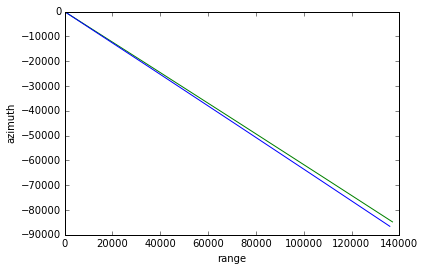

In [7]:
# finding delta and kappa (illustration of the method)
plt.plot(x_ob[:,0],y_ob[:,0],c='g') # line of first
plt.plot(x_ob[:,1],y_ob[:,1],c='b') # line of second
plt.xlabel('range')
plt.ylabel('azimuth')

# moving through range, calculating distances between the lines, taking the max as delta
ex = abs(x_ob[:,1]-x_ob[:,0]) 
why = abs(y_ob[:,1]-y_ob[:,0])
delta = np.sqrt((ex**2)+(why**2)).max()
print 'delta=', delta

kappa = 0.5*(2.*delta)**2 # the 0.5 constant is from class which cited "the literature"
print 'kappa=', kappa

## PPI

<matplotlib.colorbar.Colorbar instance at 0x116a59c68>

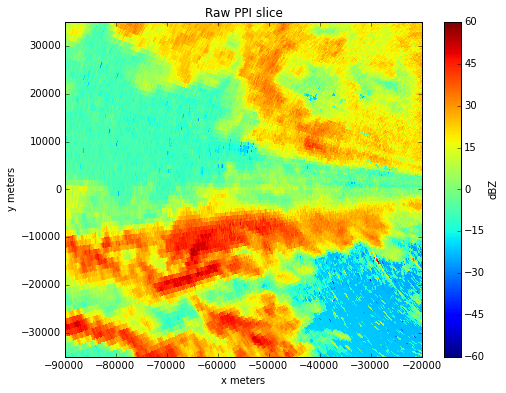

In [8]:
# Plotting the raw data for "slice" of the data region (for comparison with the weighted PPI plots)
plt.figure(figsize=(8,6))
plt.pcolormesh(x_ob,y_ob,dBZ_ob,vmin=-60,vmax=60)
plt.title('Raw PPI slice')
plt.ylabel('y meters')
plt.xlabel('x meters')
plt.xlim(-90000,-20000)
plt.ylim(-35000,35000)
plt.colorbar(label='dBZ')

In [9]:
def dBZ_ppi_barnes(x_grid,y_grid,x_ob,y_ob,dBZ_ob,kappa):
    ''' objective analysis for each point using a single pass barnes window.
    the weighting filter configuration parameters were chosen from the equation
    given in class that uses kappa (see kappa calculation above)'''
    dBZ_grid = np.zeros_like(x_grid).flatten()
    for i, (x_ref, y_ref) in enumerate(zip(x_grid.flatten(), y_grid.flatten())):
        dx = x_ob.flatten() - x_ref
        dy = y_ob.flatten() - y_ref 
        r = np.sqrt(((dx)**2.)+((dy)**2.))
        w = np.exp(-(r**2.)/kappa) # weights obs with a single pass barnes
        dBZ_grid[i] = ((dBZ_ob.flatten()*w).sum() / w.sum())
    dBZ_grid = dBZ_grid.reshape(x_grid.shape)
    return dBZ_grid

In [10]:
def dBZ_ppi_poisson(x_grid,y_grid,x_ob,y_ob,dBZ_ob,delta):
    '''objective analysis for each point using a poisson window from Harris (1978, IEEE).
    the parameters for this weighting filter uses the similarity between n/N and r/kappa
    as both ratios of fractional distances. delta was used instead of kappa because it is
    the actual distance used in calculating kappa. The 2.0 constant is used in one of the 
    scenarios in Harris (1978, IEEE)'''
    dBZ_grid = np.zeros_like(x_grid).flatten()
    for i, (x_ref, y_ref) in enumerate(zip(x_grid.flatten(), y_grid.flatten())):
        dx = x_ob.flatten() - x_ref
        dy = y_ob.flatten() - y_ref 
        r = np.sqrt(((dx)**2.)+((dy)**2.))
        w = np.exp(-2.0*np.abs(r)/delta)
        dBZ_grid[i] = ((dBZ_ob.flatten()*w).sum() / w.sum())
    dBZ_grid = dBZ_grid.reshape(x_grid.shape)
    return dBZ_grid

In [11]:
# for ppi, let's slice, so it doesn't break the internet
x_sm = x_ob[:700,150:250]
y_sm = y_ob[:700,150:250]
dBZ_sm = dBZ_ob[:700,150:250]

In [12]:
# calling the function for the gaussian weighting of the ppi slice
dBZ_bar = dBZ_ppi_barnes(x_grid,y_grid,x_sm,y_sm,dBZ_sm,kappa)

/Users/TTUatmo/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars


<matplotlib.colorbar.Colorbar instance at 0x11a69f4d0>

/Users/TTUatmo/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:584: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


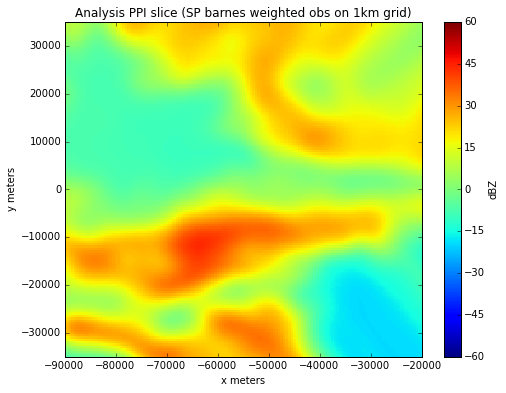

In [13]:
# plotting
plt.figure(figsize=(8,6))
plt.pcolormesh(x_grid,y_grid,dBZ_bar,vmin=-60,vmax=60) 
plt.title('Analysis PPI slice (SP barnes weighted obs on 1km grid)')
plt.ylabel('y meters')
plt.xlabel('x meters')
# plt.xlim(x_grid.min(),x_grid.max())
# plt.ylim(y_grid.min(),y_grid.max())
plt.xlim(-90000,-20000)
plt.ylim(-35000,35000)
plt.colorbar(label='dBZ')

#### The features of importance in the raw reflectivity are clearly shown at similar values in the barnes weighted plot (above), but with significant smoothing. On the same colorbar scale, I notice that the values are near the same as the raw data, however, many of the smaller features and noise found in the raw data are missing in the weighted obs. The radial nature of the raw data is replaced by the grid and reduced. This gaussian window function eliminates the frequencies beyond the nyquist and weighted the observations based upon a bell curve, so this is what I expect to see: the larger/most important features. 

In [14]:
# calling the function for the poisson weighting of the ppi slice
dBZ_poi = dBZ_ppi_poisson(x_grid,y_grid,x_sm,y_sm,dBZ_sm,delta)

<matplotlib.colorbar.Colorbar instance at 0x1107fd6c8>

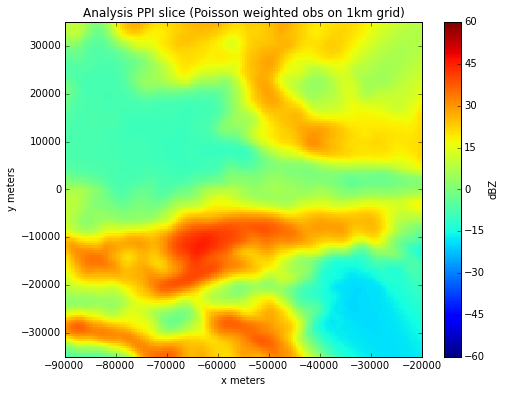

In [15]:
# plotting
plt.figure(figsize=(8,6))
plt.pcolormesh(x_grid,y_grid,dBZ_poi,vmin=-60,vmax=60) 
plt.title('Analysis PPI slice (Poisson weighted obs on 1km grid)')
plt.ylabel('y meters')
plt.xlabel('x meters')
# plt.xlim(x_grid.min(),x_grid.max())
# plt.ylim(y_grid.min(),y_grid.max())
plt.xlim(-90000,-20000)
plt.ylim(-35000,35000)
plt.colorbar(label='dBZ')

#### The poisson weighted plot shows slightly less smoothing upon the larger features in the reflectivity. There are more bumps and more changes over space in comparison to the barnes analysis, however, compared to the raw data, there is still significant reduction in noise. The poisson weighting function is similar to the gaussian function because it is also a negative exponential. Poisson windows have a sharper slope than the parabolic bell curve, which may be why the poisson PPI plot shows some additional differences that the gaussian functions smooths over. 

## RHI

In [26]:
# Using the code from HW3 to get the RHI observations
caz = az[185] # the index of the constant azimuth
print 'This is the constant azimuth I chose:', caz,'degrees'
si = np.where(az == caz)[0] # the index at which the azimuth is constant
elr = el[si] 
azr = az[si]

This is the constant azimuth I chose: 260.25 degrees


In [27]:
# creating a meshgrid with the values at the edges
azg2,rng2 = np.meshgrid(azr,r)
elg2,rng2 = np.meshgrid(elr,r)

#slicing reflectivity for constant azimuth
dBZs = dBZ[si].T

# converting to ECEF coordinates
X2,Y2,Z2 = rad.toECEF(rng2.flatten(),azg2.flatten(),elg2.flatten()) # Use degrees

# map projection from ECEF coords
mpx2,mpy2,mpz2 = proj.fromECEF(X2,Y2,Z2)
x_ob2 = np.reshape(mpx2,azg2.shape) #range
y_ob2 = np.reshape(mpy2,azg2.shape) #azimuth
z_ob2 = np.reshape(mpz2,azg2.shape) #elevation

In [28]:
# setting the data into a 500m grid
X_rhi = np.arange(np.sqrt((x_ob2**2)+(y_ob2**2)).flatten().min(),np.sqrt((x_ob2**2)+(y_ob2**2)).flatten().max(),500.)
Y_rhi = np.arange(z_ob2.flatten().min(),z_ob2.flatten().max(),500.)
x_grid_rhi,y_grid_rhi = np.meshgrid(X_rhi,Y_rhi)

<matplotlib.colorbar.Colorbar instance at 0x1123f3b48>

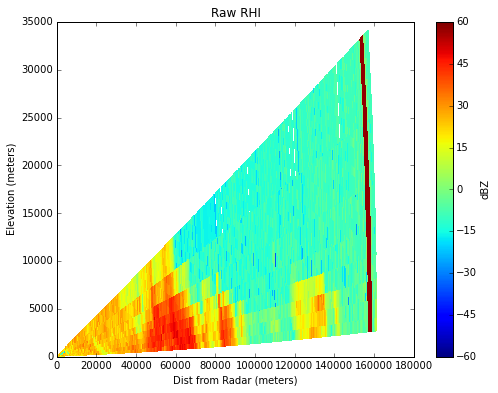

In [29]:
# plotting the raw RHI
plt.figure(figsize=(8,6))
plt.pcolormesh(np.sqrt(x_ob2**2+y_ob2**2),z_ob2,dBZs,vmin=-60,vmax=60) #magnitude 
plt.title('Raw RHI')
plt.ylabel('Elevation (meters)')
plt.xlabel('Dist from Radar (meters)')
plt.colorbar(label='dBZ')

In [30]:
def dBZ_rhi_barnes(x_grid,y_grid,x_ob,y_ob,z_ob,dBZ_ob,kappa):
    ''' objective analysis for each point using a single pass barnes analysis
    as before, but for the RHI (see PPI barnes function)'''
    dBZ_grid = np.zeros_like(x_grid).flatten()
    for i, (x_ref, y_ref) in enumerate(zip(x_grid.flatten(), y_grid.flatten())):
        dx = (np.sqrt((x_ob2**2)+(y_ob2**2))).flatten() - x_ref 
        dy = z_ob.flatten() - y_ref 
        r = np.sqrt(((dx)**2.)+((dy)**2.))
        w = np.exp(-(r**2.)/kappa) # weights obs with a single pass barnes
        dBZ_grid[i] = ((dBZ_ob.flatten()*w).sum() / w.sum())
    dBZ_grid = dBZ_grid.reshape(x_grid.shape)
    return dBZ_grid

In [31]:
# calling the function that returns reflectivity weighted on a 500m grid using a single pass gaussian window
dBZ_barnes_r = dBZ_rhi_barnes(x_grid_rhi,y_grid_rhi,x_ob2,y_ob2,z_ob2,dBZs,kappa)

<matplotlib.colorbar.Colorbar instance at 0x11a6a1f80>

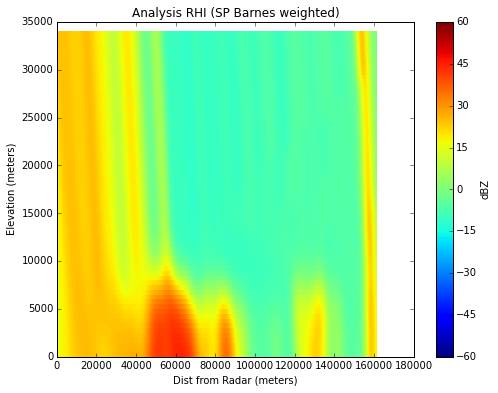

In [32]:
# plotting the analysis of the RHI with the barnes method
plt.figure(figsize=(8,6))
plt.pcolormesh(x_grid_rhi,y_grid_rhi,dBZ_barnes_r,vmin=-60,vmax=60) #magnitude 
plt.title('Analysis RHI (SP Barnes weighted)')
plt.ylabel('Elevation (meters)')
plt.xlabel('Dist from Radar (meters)')
plt.colorbar(label='dBZ')

#### The analysis RHI above shows the reflectivity weighted by a single pass barnes gaussian window plotted on a 500m grid. The plot appears square relative the the radial RHI from the raw data because of the square grid that I set. This is why the features near the radar are stretched to higher elevations - in order to fill the grid. So I can observe that the stretched reflectivity is not "real" and could be masked. The features further from the radar appear very similar to the raw rhi data, but with the smoothing discussed in the ppi analysis. The noticible radar beams and noise are eliminated and only the distinguishable features are apparent on the grid. 

In [33]:
def dBZ_rhi_poisson(x_grid,y_grid,x_ob,y_ob,z_ob,dBZ_ob,delta):
    '''objective analysis for each point using a poisson window from Harris (1978, IEEE)
    as before, but for the RHI (see PPI poisson function)'''
    dBZ_grid = np.zeros_like(x_grid).flatten()
    for i, (x_ref, y_ref) in enumerate(zip(x_grid.flatten(), y_grid.flatten())):
        dx = (np.sqrt((x_ob2**2)+(y_ob2**2))).flatten() - x_ref 
        dy = z_ob.flatten() - y_ref  
        r = np.sqrt(((dx)**2.)+((dy)**2.))
        w = np.exp(-2.0*np.abs(r)/delta)
        dBZ_grid[i] = ((dBZ_ob.flatten()*w).sum() / w.sum())
    dBZ_grid = dBZ_grid.reshape(x_grid.shape)
    return dBZ_grid

In [34]:
# calling the function that returns reflectivity on a 500m grid weighted by a poisson window
dBZ_poi_r = dBZ_rhi_poisson(x_grid_rhi,y_grid_rhi,x_ob2,y_ob2,z_ob2,dBZs,delta)

<matplotlib.colorbar.Colorbar instance at 0x11631e878>

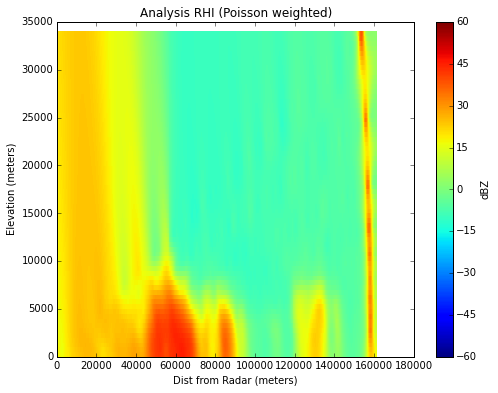

In [35]:
# plotting the analysis rhi with the poisson weight
plt.figure(figsize=(8,6))
plt.pcolormesh(x_grid_rhi,y_grid_rhi,dBZ_poi_r,vmin=-60,vmax=60) #magnitude 
plt.title('Analysis RHI (Poisson weighted)')
plt.ylabel('Elevation (meters)')
plt.xlabel('Dist from Radar (meters)')
plt.colorbar(label='dBZ')

#### There are very few differences in the poisson analysis compared to the barnes analysis of the RHI. I notice the pronouncement of some very small pieces of reflectivity, which may be due the slight difference in shape between a poisson and gaussian function (as discussed above in the PPI analysis). 